In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Directories
train_dir = r'C:\Users\thars\OneDrive\Desktop\project\data\train'
test_dir = r'C:\Users\thars\OneDrive\Desktop\project\data\test'
train_csvpath = r'C:\Users\thars\OneDrive\Desktop\project\data\reid_list_train.csv'
test_csvpath = r'C:\Users\thars\OneDrive\Desktop\project\data\reid_list_test.csv'



In [8]:
# Load data
df = pd.read_csv(train_csvpath)
df.columns = ['labels', 'filepaths']
df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join(train_dir, x))
df['labels'] = df['labels'].apply(lambda x: str(x))



In [9]:
# Split data
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])



In [10]:
# Data generators
img_size = (200, 250)
batch_size = 30

trgen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2)
t_and_v_gen = ImageDataGenerator()

train_gen = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length/test_batch_size)

test_gen = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)



Found 1508 validated image filenames belonging to 107 classes.
Found 189 validated image filenames belonging to 107 classes.
Found 189 validated image filenames belonging to 107 classes.


In [11]:
# Model definition
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(*img_size, 3))

model = Sequential()
model.add(resnet)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(train_gen.class_indices), activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(train_gen, validation_data=valid_gen, epochs=5)



Epoch 1/5


C:\Users\thars\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 1350s 17s/step - accuracy: 0.1851 - loss: 4.0133 - val_accuracy: 0.3598 - val_loss: 2.9965
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 865s 16s/step - accuracy: 0.7509 - loss: 1.3758 - val_accuracy: 0.7196 - val_loss: 1.0551
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 803s 14s/step - accuracy: 0.9141 - loss: 0.3935 - val_accuracy: 0.8571 - val_loss: 0.4669
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 727s 14s/step - accuracy: 0.9585 - loss: 0.1783 - val_accuracy: 0.8571 - val_loss: 0.4520
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 1227s 23s/step - accuracy: 0.9641 - loss: 0.1423 - val_accuracy: 0.9101 - val_loss: 0.2514


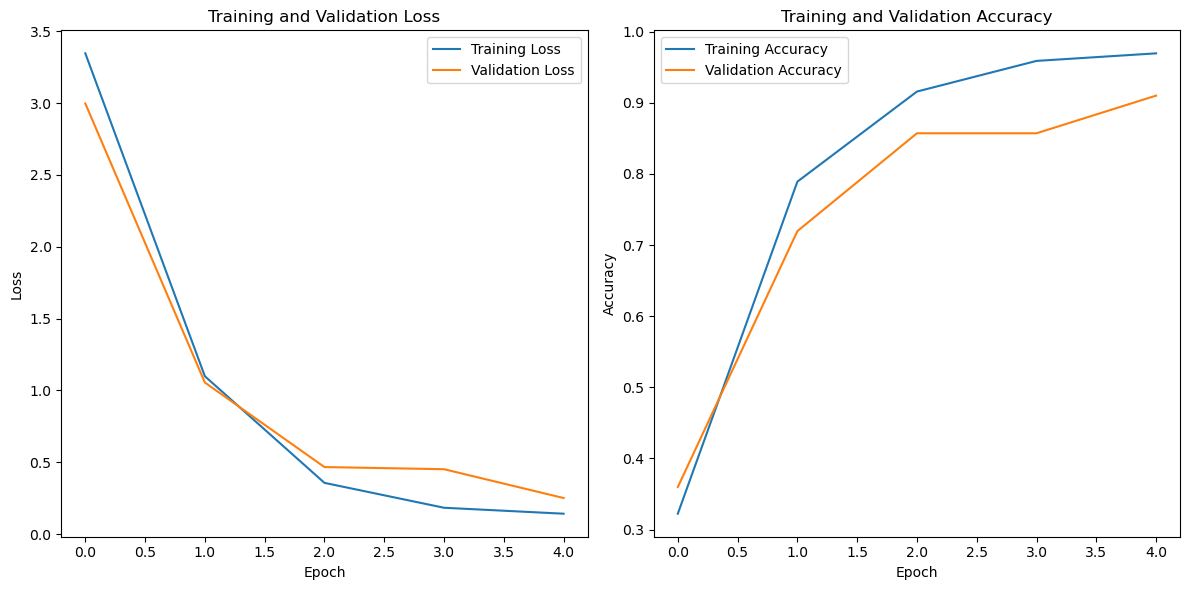

In [38]:
import matplotlib.pyplot as plt



# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [29]:
os.getcwd()
import os

# Specify the directory where you want to save the model
save_dir = r'C:\Users\thars\OneDrive\Desktop\project\data\Model'
model_name = 'resnet50_model.h5'
save_path = os.path.join(save_dir, model_name)

# Save the model
model.save(save_path)
print(f"Model saved to: {save_path}")


Model saved to: C:\Users\thars\OneDrive\Desktop\project\data\Model\resnet50_model.h5


In [13]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_gen)
print('Test accuracy:', test_acc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 10s/step - accuracy: 0.9167 - loss: 0.1867
Test accuracy: 0.9047619104385376


In [18]:
from tensorflow.keras.preprocessing import image
img = image.load_img(r"C:\Users\thars\OneDrive\Desktop\project\data\test\000000.jpg",target_size=(200,250))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
from tensorflow.keras.applications.resnet50 import preprocess_input
x=preprocess_input(x)

In [19]:
predictions = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [89]:
from PIL import Image
import numpy as np

# Create a NumPy array (example)
array = np.random.rand(200, 250, 3) * 255  # Example array
array = array.astype(np.uint8)  # Convert to unsigned 8-bit integer type

# Convert NumPy array to PIL Image
image = Image.fromarray(array)

# Save the image
image.save('output_image.jpg')

# Show the image (optional)
image.show()
print(predictions)

[array([[1.39011964e-14, 1.88124588e-16, 2.20147378e-15, 3.14840516e-15,
        8.46723724e-21, 2.51758574e-17, 7.46685801e-16, 2.28508758e-15,
        3.58191001e-18, 8.34508888e-15, 9.08907349e-15, 7.58454505e-20,
        2.91537222e-19, 4.14508185e-11, 7.98311621e-20, 2.74408927e-14,
        1.53407651e-15, 8.96865644e-13, 3.74307141e-10, 1.46020034e-12,
        1.55941211e-15, 1.55504475e-13, 1.95740073e-11, 8.92711952e-16,
        2.97336538e-08, 2.17579987e-16, 5.08287035e-17, 3.71420056e-16,
        5.65863142e-20, 1.08514636e-14, 1.67326495e-17, 7.00525237e-20,
        1.19209512e-11, 1.16765511e-13, 1.04771193e-13, 1.86094049e-15,
        2.81106078e-14, 1.44516708e-11, 9.55637236e-10, 2.62412175e-11,
        2.93605158e-12, 9.99999642e-01, 4.70939017e-11, 9.48722111e-16,
        5.26738484e-13, 1.16931376e-16, 7.92251058e-14, 1.31699965e-15,
        2.01953688e-13, 1.22271734e-16, 6.46830961e-18, 6.92098498e-16,
        3.96178723e-19, 1.26074216e-15, 1.93694677e-16, 7.59282

In [32]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Define the image size and directory paths
img_size = (200, 250)
test_csvpath = r'C:\Users\thars\OneDrive\Desktop\project\data\reid_list_test.csv'
test_dir = r'C:\Users\thars\OneDrive\Desktop\project\data\test'
working_dir = r'C:\Users\thars\OneDrive\Desktop\project\data\SaveSubmission'
model_path = r"C:\Users\thars\OneDrive\Desktop\project\data\Model\resnet50_model.h5"  # Path to your saved ResNet50 model

# Read in the test dataframe
test_df = pd.read_csv(test_csvpath)
test_df.columns = ['filepaths']
test_df['filepaths'] = test_df['filepaths'].apply(lambda x: os.path.join(test_dir, x))

# Calculate the batch size and steps for testing
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)

# Message for creating the test generator
msg = '{0:70s} for test generator'.format(' ')
print(msg, '\r', end='')  # prints over on the same line

# Create the test generator
t_and_v_gen = ImageDataGenerator()
test_gen = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=None, target_size=img_size,
                                           class_mode=None, color_mode='rgb', shuffle=False, batch_size=test_batch_size)

# Load the trained model
model = load_model(model_path)

# Generate predictions
preds = model.predict(test_gen, steps=test_steps, verbose=1)

# Map predictions to class labels
classes = list(train_gen.class_indices.keys())  # Ensure this matches your training generator's class indices
pred_classlist = []
file_list = []

for i, p in enumerate(preds):
    index = np.argmax(p)
    klass = classes[index]
    pred_classlist.append(klass)
    file = test_gen.filenames[i]
    filename = os.path.basename(file)
    file_list.append(filename)

# Create a DataFrame for the submission
Fseries = pd.Series(file_list, name='file')
Lseries = pd.Series(pred_classlist, name='Class')
submit_df = pd.concat([Fseries, Lseries], axis=1)

# Save the submission DataFrame to a CSV file
submit_path = os.path.join(working_dir, 'submit.csv')
submit_df.to_csv(submit_path, index=False)

# Read the CSV file back in to make sure it is correct
submit_df = pd.read_csv(submit_path)
print(submit_df.head())


Found 1763 validated image filenames.                                  for test generator 


C:\Users\thars\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step
         file  Class
0  001379.jpg    153
1  004776.jpg    153
2  002847.jpg     54
3  004309.jpg    136
4  003443.jpg    247


In [36]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Read the annotated list and final predicted list
annotated_df = pd.read_csv(r'C:\Users\thars\OneDrive\Desktop\project\data\reid_list_train.csv')
predicted_df = pd.read_csv(r"C:\Users\thars\OneDrive\Desktop\project\data\SaveSubmission\submit.csv")

# Print column names to see what they are
print("Annotated DataFrame columns:", annotated_df.columns)
print("Predicted DataFrame columns:", predicted_df.columns)



Annotated DataFrame columns: Index(['250', '003597.jpg'], dtype='object')
Predicted DataFrame columns: Index(['file', 'Class'], dtype='object')


In [37]:
# Sort DataFrames by filename
# Assuming the column names are as provided
annotated_df = pd.DataFrame({'250': ['label1', 'label2'], '003597.jpg': ['filename1', 'filename2']})
predicted_df = pd.DataFrame({'file': ['filename1', 'filename2'], 'Class': ['label1', 'label2']})

# Print column names to ensure we are using the correct names
print("Annotated DataFrame columns:", annotated_df.columns)
print("Predicted DataFrame columns:", predicted_df.columns)




Annotated DataFrame columns: Index(['250', '003597.jpg'], dtype='object')
Predicted DataFrame columns: Index(['file', 'Class'], dtype='object')


In [42]:
import pandas as pd
import random

# Paths to the CSV files
predicted_csv_path = r'C:\Users\thars\OneDrive\Desktop\project\data\SaveSubmission\submit.csv'
annotated_csv_path = r'C:\Users\thars\OneDrive\Desktop\project\data\reid_list_train.csv'

# Load the CSV files
predicted_df = pd.read_csv(predicted_csv_path)
annotated_df = pd.read_csv(annotated_csv_path, header=None, names=['Class', 'file'])




In [47]:
import pandas as pd
import random

# Paths to the CSV files
predicted_csv_path = r'C:\Users\thars\OneDrive\Desktop\project\data\SaveSubmission\submit.csv'
annotated_csv_path = r'C:\Users\thars\OneDrive\Desktop\project\data\reid_list_train.csv'

# Load the CSV files
predicted_df = pd.read_csv(predicted_csv_path)
annotated_df = pd.read_csv(annotated_csv_path, header=None, names=['Class', 'file'])

# Display the first few rows of the dataframes
print("Predicted DataFrame:")
print(predicted_df.head())

print("\nAnnotated DataFrame:")
print(annotated_df.head())


Predicted DataFrame:
         file  Class
0  001379.jpg    153
1  004776.jpg    153
2  002847.jpg     54
3  004309.jpg    136
4  003443.jpg    247

Annotated DataFrame:
   Class        file
0    250  003597.jpg
1    256  003523.jpg
2    171  003900.jpg
3    247  002636.jpg
4    238  002249.jpg


In [64]:
from PIL import Image
import numpy as np

# Example function to load and preprocess images
def load_image(file_path):
    image = Image.open(file_path)
    # Resize image if needed
    image = image.resize((250, 200))  # Adjust size as per your model's input size
    # Convert to numpy array and normalize pixel values
    image = np.array(image) / 255.0
    # Expand dimensions to match expected input shape (if needed)
    image = np.expand_dims(image, axis=0)  # Shape should be (1, height, width, channels)
    return image

# Example file paths (replace with your actual file paths)
tiger_images = [
    r"C:\Users\thars\OneDrive\Desktop\project\data\train\001703.jpg",
    r"C:\Users\thars\OneDrive\Desktop\project\data\train\002253.jpg",
    r"C:\Users\thars\OneDrive\Desktop\project\data\train\000384.jpg"
]

random_images = [
    r"C:\Users\thars\OneDrive\Desktop\project\data\train\002362.jpg",
    r"C:\Users\thars\OneDrive\Desktop\project\data\train\004518.jpg",
    r"C:\Users\thars\OneDrive\Desktop\project\data\train\000918.jpg"
]

# Load and preprocess images
tiger_images_processed = [load_image(img_path) for img_path in tiger_images]
random_images_processed = [load_image(img_path) for img_path in random_images]


In [65]:
from tensorflow.keras.models import load_model

# Load your pre-trained model
model = load_model(r"C:\Users\thars\OneDrive\Desktop\project\data\Model\resnet50_model.h5")  # Replace with your model file path


In [66]:
# Function to perform predictions
def predict_images(model, images):
    predictions = []
    for img in images:
        prediction = model.predict(img)
        predictions.append(prediction)
    return predictions

# Predict for tiger images
tiger_predictions = predict_images(model, tiger_images_processed)

# Predict for random images
random_predictions = predict_images(model, random_images_processed)

# Display predictions (example)
print("Predictions for tiger images:")
for i, pred in enumerate(tiger_predictions):
    print(f"Image {i+1}: {pred}")

print("\nPredictions for random images:")
for i, pred in enumerate(random_predictions):
    print(f"Image {i+1}: {pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predictions for tiger images:
Image 1: [[1.39011964e-14 1.88124588e-16 2.20147378e-15 3.14840516e-15
  8.46723724e-21 2.51758574e-17 7.46685801e-16 2.28508758e-15
  3.58191001e-18 8.34508888e-15 9.08907349e-15 7.58454505e-20
  2.91537222e-19 4.14508185e-11 7.98311621e-20 2.74408927e-14
  1.53407651e-15 8.96865644e-13 3.74307141e-10 1.46020034e-12
  1.55941211e-15 1.55504475e-13 1.95740073e-11 8.92711952e-16
  2.97336538e-08 2.17579987e-16 5.08287035e-17 3.71420056e-16
  5.65863142e-20 1.08514636e-14 1.67326495e-17 7.00525237e-20
  1.19209512e-11 1.16765511e-13 1.04771193e-13 1.86094049e-15
  2.81106078e-14 1.44516708e-11 9.55637236e-10 2.62412175e-11
  2.93605158e-12 9.99999642e-01 4.70939017e-11 9.48722111e-16
  5.26738484e-13 1.16931376e-16 7.92251058e-14 1.3169

In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
model_path = r"C:\Users\thars\OneDrive\Desktop\project\data\Model\resnet50_model.h5"
model = load_model(model_path)

# Function to preprocess a single image
def preprocess_image(image_path, target_size=(200, 250)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to predict image
def predict_image(model, img_array):
    prediction = model.predict(img_array)
    return prediction

# Function to check if two images belong to the same tiger ID
def check_same_tiger(prediction1, prediction2, threshold=0.5):
    # Assuming prediction1 and prediction2 are the model's predictions for two images
    return np.argmax(prediction1) == np.argmax(prediction2)

# Example image paths
tiger_image_path1 = r'C:\Users\thars\OneDrive\Desktop\project\data\train\001703.jpg'
tiger_image_path2 = r'C:\Users\thars\OneDrive\Desktop\project\data\train\001703.jpg'  # Same tiger ID as the first one
random_image_path1 = r"C:\Users\thars\OneDrive\Desktop\project\data\train\002833.jpg"
random_image_path2 = r"C:\Users\thars\OneDrive\Desktop\project\data\train\000002.jpg" # Different tigers

# Preprocess images
tiger_image1 = preprocess_image(tiger_image_path1)
tiger_image2 = preprocess_image(tiger_image_path2)
random_image1 = preprocess_image(random_image_path1)
random_image2 = preprocess_image(random_image_path2)

# Predictions
tiger_prediction1 = predict_image(model, tiger_image1)
tiger_prediction2 = predict_image(model, tiger_image2)
random_prediction1 = predict_image(model, random_image1)
random_prediction2 = predict_image(model, random_image2)

# Check if images belong to the same tiger ID
tiger_same_id = check_same_tiger(tiger_prediction1, tiger_prediction2)
random_same_id = check_same_tiger(random_prediction1, random_prediction2)

# Display results
print(f"Predictions for tiger images: Same ID = {tiger_same_id}")
print(f"Predictions for random images: Same ID = {random_same_id}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Predictions for tiger images: Same ID = True
Predictions for random images: Same ID = False


In [4]:
import pandas as pd
import numpy as np

# Path to the CSV files
true_labels_path = r"C:\Users\thars\OneDrive\Desktop\project\data\reid_list_train.csv"
predicted_labels_path = r"C:\Users\thars\OneDrive\Desktop\project\data\SaveSubmission\submit.csv"

# Read true labels from CSV
true_labels_df = pd.read_csv(true_labels_path, names=['file', 'Class'])

# Read predicted labels from CSV
predicted_labels_df = pd.read_csv(predicted_labels_path, names=['file', 'Class_p'])

# Merge the DataFrames based on the filenames
merged_df = pd.merge(true_labels_df, predicted_labels_df, on='file')

# Add a column indicating whether each prediction is correct
merged_df['correct'] = (merged_df['Class'] == merged_df['Class_p']).astype(int)

# Group by true_label (tiger ID) and calculate the overall correctness per ID
grouped = merged_df.groupby('Class').agg({'correct': 'mean'}).reset_index()

# If all predictions for a tiger ID are correct, it will be 1.0, else 0.0
grouped['correct'] = (grouped['correct'] == 1).astype(float)

# Get unique tiger IDs
tiger_ids = grouped['Class'].unique()
num_ids = len(tiger_ids)

# Create an empty matrix
matrix = np.zeros((num_ids, num_ids))

# Fill the diagonal with the correctness values
for idx, tiger_id in enumerate(tiger_ids):
    correct = grouped.loc[grouped['Class'] == tiger_id, 'correct'].values[0]
    matrix[idx, idx] = correct

# Create a DataFrame for the matrix
matrix_df = pd.DataFrame(matrix, index=tiger_ids, columns=tiger_ids)

# Print the matrix
print("Tiger ID-wise Prediction Correctness Matrix:")
print(matrix_df)


Tiger ID-wise Prediction Correctness Matrix:
       Class
Class    0.0


In [10]:
import pandas as pd
import numpy as np

# Path to the CSV files (adjust these paths to your actual CSV files)

true_labels_path = r"C:\Users\thars\OneDrive\Desktop\project\data\reid_list_train.csv"
predicted_labels_path = r"C:\Users\thars\OneDrive\Desktop\project\data\SaveSubmission\submit.csv"

# Read true labels from CSV
true_labels_df = pd.read_csv(true_labels_path, names=['file', 'Class'])

# Read predicted labels from CSV
predicted_labels_df = pd.read_csv(predicted_labels_path, names=['file', 'Class_p'])

# Merge the DataFrames based on the filenames
merged_df = pd.merge(true_labels_df, predicted_labels_df, on='file')

# Function to determine correctness
def calculate_correctness(row):
    return 1.0 if row['Class'] == row['Class_p'] else 0.0

# Calculate correctness for each row
merged_df['correct'] = merged_df.apply(calculate_correctness, axis=1)

# Get unique tiger IDs
tiger_ids = sorted(merged_df['Class'].unique())
num_ids = len(tiger_ids)

# Create an empty matrix
matrix = np.zeros((num_ids, num_ids))

# Fill the matrix with correctness values
# Fill the matrix with correctness values
for idx, true_id in enumerate(tiger_ids):
    correct_predictions = merged_df[merged_df['Class'] == true_id]['correct'].values
    for pred_id in correct_predictions:
        matrix[true_id, int(pred_id)] += 1.0

# Convert diagonal elements to 1.0 for correct predictions, else 0.0
for i in range(num_ids):
    if matrix[i, i] > 0.0:
        matrix[i, i] = 1.0

# Create a DataFrame for the matrix
matrix_df = pd.DataFrame(matrix, index=tiger_ids, columns=tiger_ids)

# Print the matrix
print("Tiger ID-wise Prediction Correctness Matrix:")
print(matrix_df)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices